In [31]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
#set latex
plt.rc('text', usetex=True)

In [28]:
# auxiliary functions for reading data from files
def read_chi_k(file, beta, n_sites, n_omega):
    omega = 2*np.arange(-n_omega, n_omega+1, 1)*np.pi/beta
    momenta = np.arange(0, n_sites)
    chi_ch = np.zeros(( len(omega),len(momenta)), dtype=complex)
    chi_sp = np.zeros(( len(omega),len(momenta)), dtype=complex)
    chi_s = np.zeros(( len(omega),len(momenta)), dtype=complex)
    for j in np.arange(np.shape(file)[0]):
        tol = 1e-5
        ind_q = np.where(np.abs(file[j, 0] - momenta) <= tol)[0][0]
        ind_om = np.where(np.abs(file[j, 1] - omega) <= tol)[0][0]
        chi_ch[ ind_om, ind_q] = file[j, 2] + file[j, 3]*1j
        chi_sp[ind_om, ind_q] = file[j, 4] + file[j, 5]*1j
        chi_s[ind_om, ind_q] = file[j, 6] + file[j, 7]*1j
    return chi_ch, chi_sp, chi_s, omega

def read_chi0_cglattice_pp_k(file, beta, n_sites, n_nu):
    nu = (2*np.arange(-n_nu, n_nu, 1)+1)*np.pi/beta
    momenta = np.arange(0, n_sites)
    chi0_cglattice_pp = np.zeros(( len(nu),len(momenta)), dtype=complex)
    for j in np.arange(np.shape(file)[0]):
        tol = 1e-5
        ind_k = np.where(np.abs(file[j, 0] - momenta) <= tol)[0][0]
        ind_nu = np.where(np.abs(file[j, 1] - nu) <= tol)[0][0]
        chi0_cglattice_pp[ ind_nu, ind_k] = file[j, 2] + file[j, 3]*1j
    return chi0_cglattice_pp

def compute_screened_interaction(U, chi_ch, chi_sp, chi_s):
    W_ch = U + 1/2 * U * chi_ch * U
    W_sp = -1*U + 1/2 * U * chi_sp * U
    W_s = 2*U + 2 * U * chi_s * U
    return W_ch, W_sp, W_s

def read_gamma_k(file, beta, n_sites, n_omega, n_nu):
    omega = 2*np.arange(-n_omega, n_omega+1, 1)*np.pi/beta
    nu = (2*np.arange(-n_nu, n_nu, 1)+1)*np.pi/beta
    momenta = np.arange(0, n_sites)
    gamma_ch = np.zeros((len(omega),len(momenta), len(nu), len(momenta)), dtype=complex)
    gamma_sp = np.zeros((len(omega),len(momenta), len(nu), len(momenta)), dtype=complex)
    gamma_s = np.zeros((len(omega),len(momenta), len(nu), len(momenta)), dtype=complex)
    for j in np.arange(np.shape(file)[0]):
        tol = 1e-5
        ind_q = np.where(np.abs(file[j, 0] - momenta) <= tol)[0][0]
        ind_k = np.where(np.abs(file[j, 1] - momenta) <= tol)[0][0]
        ind_om = np.where(np.abs(file[j, 2] - omega) <= tol)[0][0]
        ind_nu = np.where(np.abs(file[j, 3] - nu) <= tol)[0][0]
        gamma_ch[ind_om, ind_q, ind_nu, ind_k] = file[j, 4] + file[j, 5]*1j
        gamma_sp[ind_om, ind_q, ind_nu, ind_k] = file[j, 6] + file[j, 7]*1j
        gamma_s[ind_om, ind_q, ind_nu, ind_k] = file[j, 8] + file[j, 9]*1j
    return gamma_ch, gamma_sp, gamma_s, omega, nu

# auxiliary functions for adding cluster momenta
def add_k_ind(k1,k2,k_points):
  return np.argmin(np.array([np.linalg.norm(i) for i in (k_points % (2*np.pi) - (k1+k2) % (2*np.pi))]))

def add_k(k1,k2,k_points):
  return k_points[np.argmin(np.array([np.linalg.norm(i) for i in (k_points % (2*np.pi) - (k1+k2) % (2*np.pi))]))]

def convert_value(value):
    special_values = {
        0: "0",
        np.pi: "\\pi",
        np.pi / 2: "\\pi/2",
        -np.pi: "-\\pi",
        -np.pi / 2: "-\\pi/2"
    }
    for special_value, label in special_values.items():
        if abs(value - special_value) < 1e-5:
            return label
    return "NA"

def convert_array(arr):
    result = []
    for elem in arr:
        converted = [convert_value(val) for val in elem]
        result.append("$" + ",".join(converted) + "$" if len(elem) == 2 else f"${converted[0]}$")
    return result


In [29]:
n_omega= 60 # number of positive bosonic frequency
n_nu= 40 # number of positive fermionic frequency
n_sites = 8 # number of k points
U = 7 
beta = 10 # needed to be changed
n = 0.95 # needed to be changed
directory = "/home/umyangyu/run/SBE_eigen/data/U{}beta{}n{}/".format(U,beta,n) # needed to be changed

In [42]:
### read k points
clusterh5 = h5py.File(directory+"cluster.h5", 'r')
lattice="Betts2D-8A"
dim=int(clusterh5['{}/cluster_coordinates/size2'.format(lattice)][()])
k_points = clusterh5['{}/cluster_momenta/values'.format(lattice)][()]
k_points = k_points.reshape(int(len(k_points)/dim), dim)
k_points_str = convert_array(k_points)

print("cluster k points are:")
for i in range(len(k_points)):
    print(k_points_str[i])

def test_add_k_funcs():
    k_pi_pi = k_points[3]
    k_pihalf_mpihalf = k_points[5]
    k_pi_pi_pihalf_mpihalf = k_points[4]
    if add_k_ind(k_pi_pi,k_pihalf_mpihalf,k_points) != 4:
        raise ValueError("add_k_ind is wrong")
    if np.linalg.norm(add_k(k_pi_pi,k_pihalf_mpihalf,k_points) - k_pi_pi_pihalf_mpihalf) > 1e-10:
        raise ValueError("add_k is wrong")
    
test_add_k_funcs()

cluster k points are:
$\pi/2,\pi/2$
$-\pi/2,-\pi/2$
$0,0$
$\pi,\pi$
$-\pi/2,\pi/2$
$\pi/2,-\pi/2$
$0,\pi$
$\pi,0$


In [43]:
### read (spin) susceptibility 

chi_file = np.loadtxt(directory+"chi_k.dat")
chi_ch, chi_sp, chi_s, omega = read_chi_k(chi_file, beta, n_sites, n_omega)
print("chi_sp has the shape: ", chi_sp.shape)
W_ch, W_sp, W_s = compute_screened_interaction(U, chi_ch, chi_sp, chi_s)
print("W_sp has the shape: ", W_sp.shape)

### wrap the screened interaction
def W(om_ind, q, flavor):
    q_ind = add_k_ind(q,np.array([0.,0.]),k_points)
    if flavor == "ch":
        om_shp = W_ch.shape[0]
    elif flavor == "sp":
        om_shp = W_sp.shape[0]
    elif flavor == "si":
        om_shp = W_s.shape[0]
    else:
        raise ValueError("flavor should be sp, ch or si")
    
    if om_ind+int(om_shp/2) < 0 or om_ind+int(om_shp/2) >= om_shp:
        if flavor == "ch":
            return U
        elif flavor == "sp":
            return -1*U
        elif flavor == "si":
            return 2*U
    else:
        if flavor == "ch":
            return W_ch[om_ind+int(om_shp/2), q_ind]
        elif flavor == "sp":
            return W_sp[om_ind+int(om_shp/2), q_ind]
        elif flavor == "si":
            return W_s[om_ind+int(om_shp/2), q_ind]
        else:
            raise ValueError("flavor should be sp, ch or si")

chi_sp has the shape:  (121, 8)
W_sp has the shape:  (121, 8)


In [13]:
### read coarse-grained chi0 in pp channel

chi0_cglattice_pp_file = np.loadtxt(directory+"chi0_cglattice_pp_reduced.dat")
chi0_cglattice_pp=read_chi0_cglattice_pp_k(chi0_cglattice_pp_file, beta, n_sites, n_nu)
chi0_cglattice_pp = chi0_cglattice_pp/(-beta*n_sites) # To be consisten with the notation below Eq (5) of PRL 96, 047005 (2006), I think there should be an (-beta*n_sites) needed to be divided
print("chi0_cglattice_pp has the shape: ", chi0_cglattice_pp.shape)

chi0_cglattice_pp has the shape:  (80, 8)


In [32]:
### read Hedin vertex
gamma_bar_file = np.loadtxt(directory+"gamma_bar_k.dat")
gamma_file = np.loadtxt(directory+"gamma_k.dat")
gamma_ch, gamma_sp, gamma_s, omega, nu = read_gamma_k(gamma_file, beta, n_sites, n_omega, n_nu)
gamma_ch_bar, gamma_sp_bar, gamma_s_bar, omega, nu = read_gamma_k(gamma_bar_file, beta, n_sites, n_omega, n_nu)
print("gamma_sp has the shape: ", gamma_sp.shape)
print("gamma_sp_bar has the shape: ", gamma_sp_bar.shape)

### wrap the boson-fermion vertex

def gamma(om_ind,q,nu_ind,k,flavor,bar=False):
  q_ind = add_k_ind(q,np.array([0.,0.]),k_points)
  k_ind = add_k_ind(k,np.array([0.,0.]),k_points)
  if flavor == "ch":
    if bar:
      shp_om = gamma_ch_bar.shape[0]
      shp_nu = gamma_ch_bar.shape[2]
    else:
      shp_om = gamma_ch.shape[0]
      shp_nu = gamma_ch.shape[2]
  elif flavor == "sp":
    if bar:
      shp_om = gamma_sp_bar.shape[0]
      shp_nu = gamma_sp_bar.shape[2]
    else:
      shp_om = gamma_sp.shape[0]
      shp_nu = gamma_sp.shape[2]
  elif flavor == "si":
    if bar:
      shp_om = gamma_s_bar.shape[0]
      shp_nu = gamma_s_bar.shape[2]
    else:
      shp_om = gamma_s.shape[0]
      shp_nu = gamma_s.shape[2]
  else:
    raise Exception("undefined flavor")
    
  if om_ind+int(shp_om/2) < 0 or om_ind+int(shp_om/2) >= shp_om or nu_ind+int(shp_nu/2) < 0 or nu_ind+int(shp_nu/2) >= shp_nu:
    if flavor == "ch" or flavor == "sp":
      return 1.0
    elif flavor == "si":
      return -1.0
    else:
      raise Exception("undefined flavor")
  else:
    if flavor == "ch":
      if bar:
        return gamma_ch_bar[om_ind+int(shp_om/2),q_ind,nu_ind+int(shp_nu/2),k_ind]
      else:
        return gamma_ch[om_ind+int(shp_om/2),q_ind,nu_ind+int(shp_nu/2),k_ind]
    elif flavor == "sp":
      if bar:
        return gamma_sp_bar[om_ind+int(shp_om/2),q_ind,nu_ind+int(shp_nu/2),k_ind]
      else:
        return gamma_sp[om_ind+int(shp_om/2),q_ind,nu_ind+int(shp_nu/2),k_ind]
    elif flavor == "si":
      if bar:
        return gamma_s_bar[om_ind+int(shp_om/2),q_ind,nu_ind+int(shp_nu/2),k_ind]
      else:
        return gamma_s[om_ind+int(shp_om/2),q_ind,nu_ind+int(shp_nu/2),k_ind]
    else:
      raise Exception("undefined flavor")
    
def gamma_bar(om_ind,q,nu_ind,k,flavor):
  return gamma(om_ind,q,nu_ind,k,flavor,bar=True)

gamma_sp has the shape:  (121, 8, 80, 8)
gamma_sp_bar has the shape:  (121, 8, 80, 8)


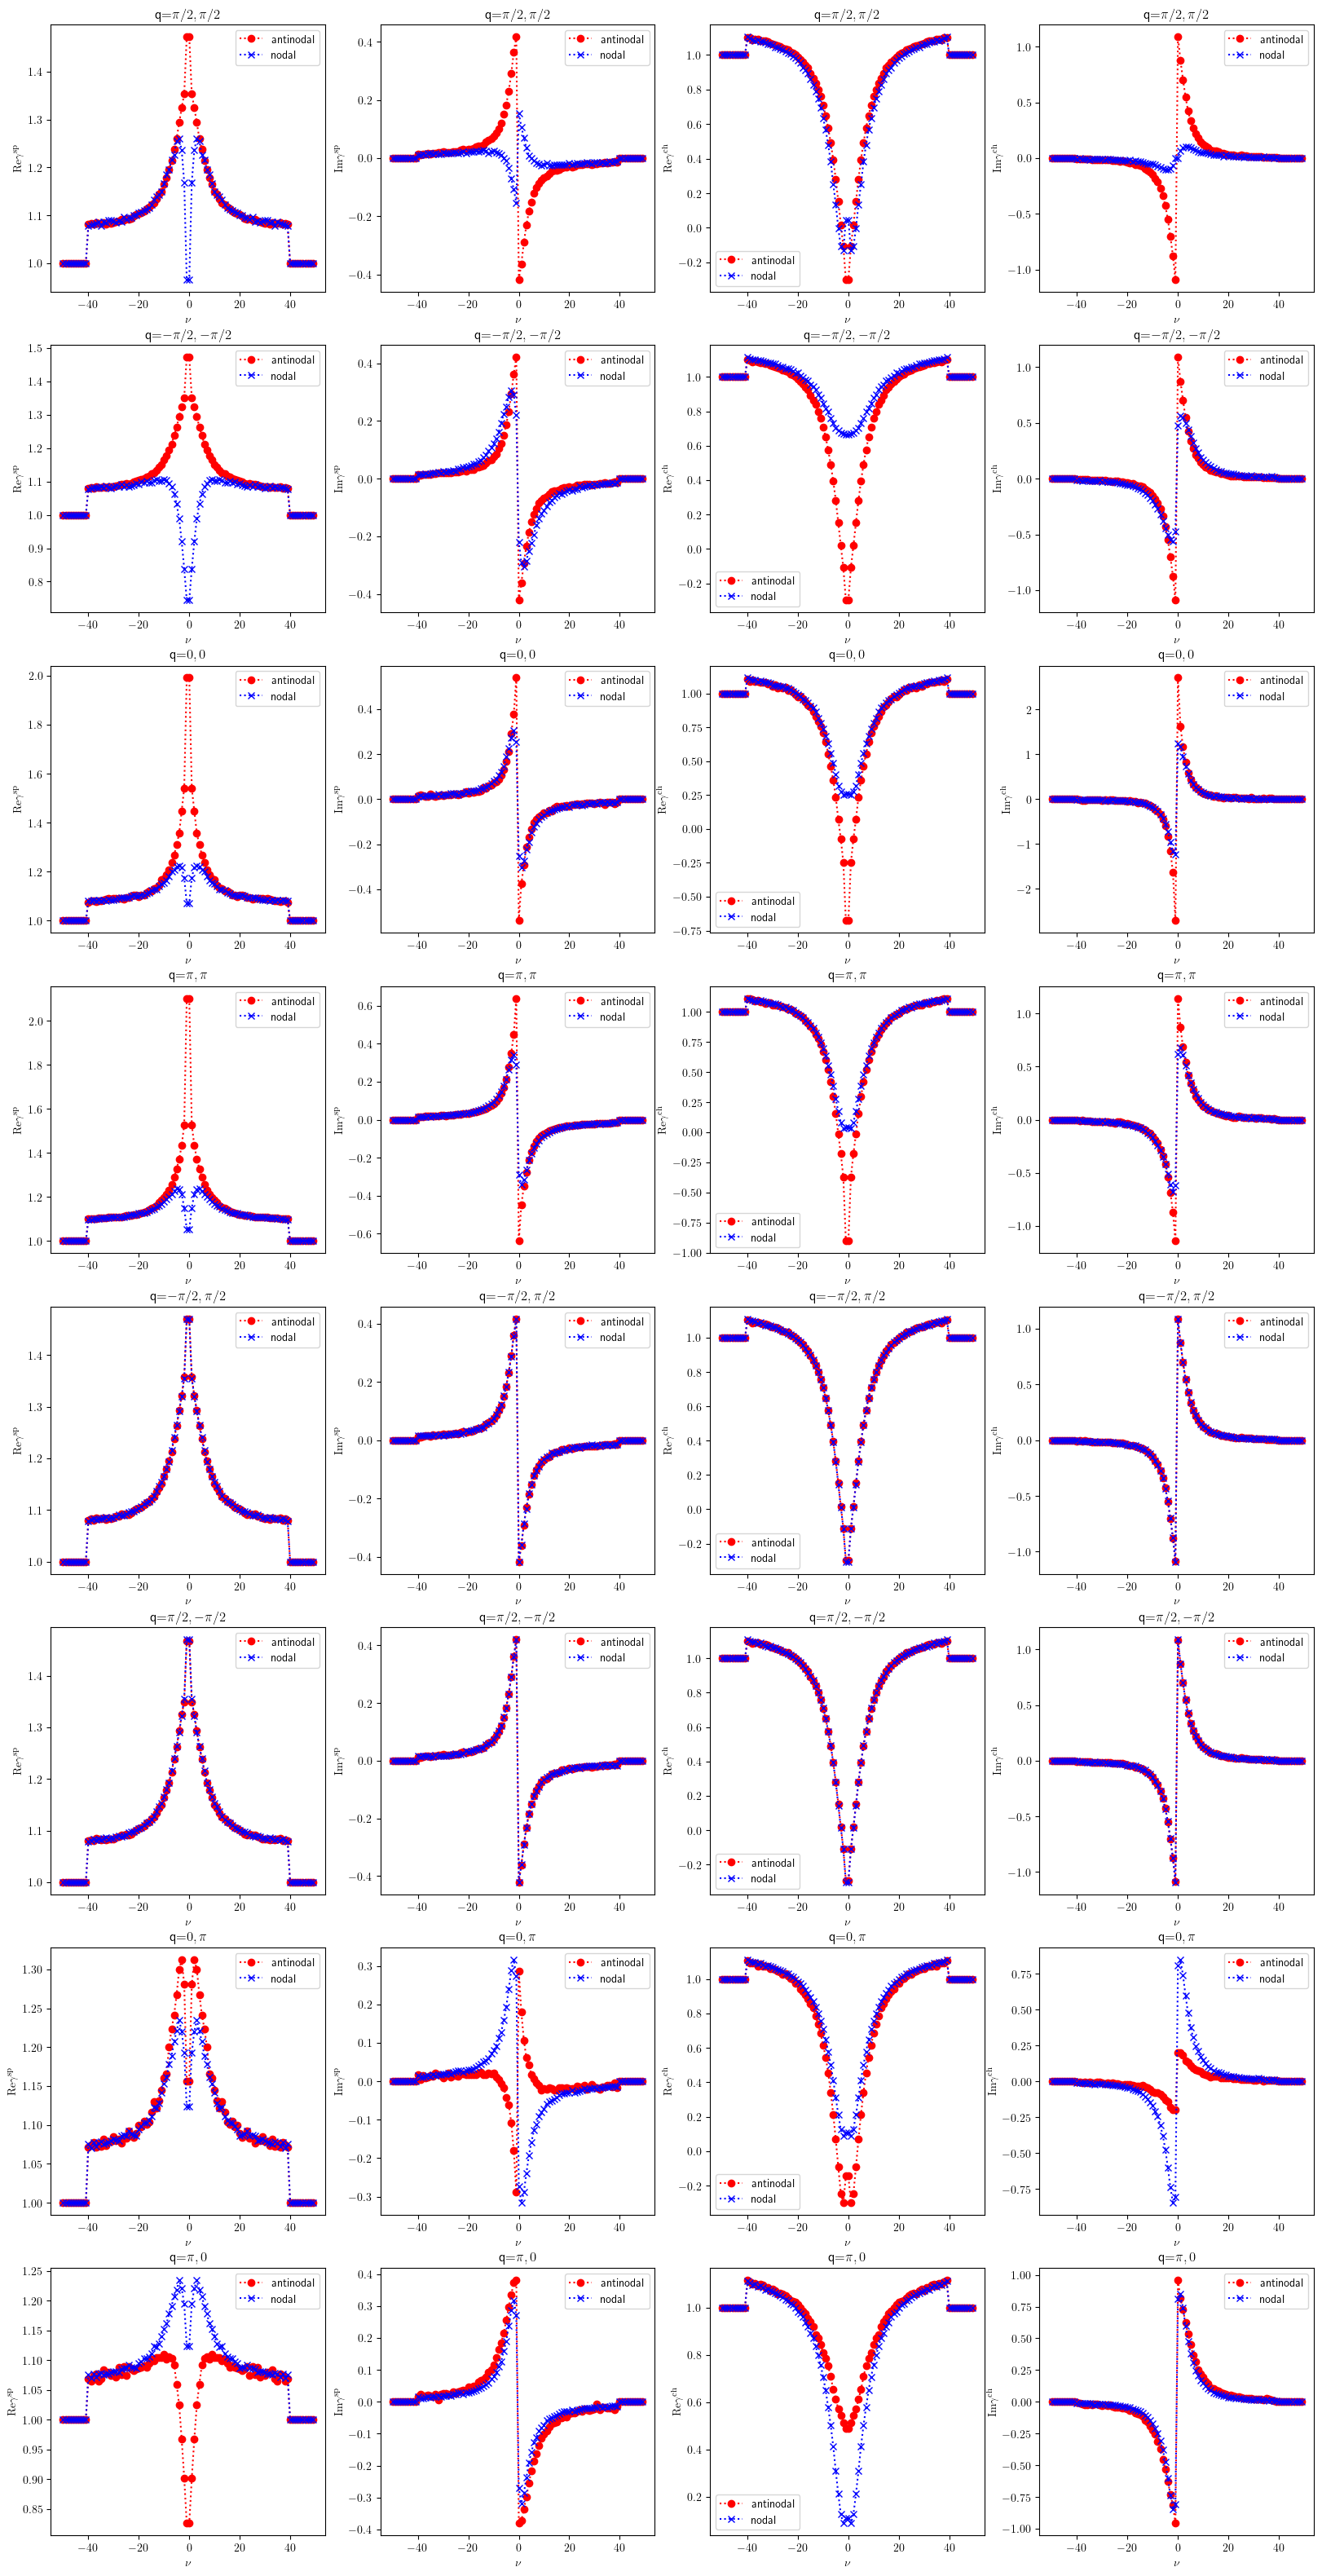

In [40]:

k_antinodal = k_points[-1]
k_nodal = k_points[0]
nu_range = np.arange(-50,50)

fig, axes = plt.subplots(len(k_points),4,figsize=(5*4,5*len(k_points)))
for q in k_points:
    q_ind = add_k_ind(q,np.array([0.,0.]),k_points)
    gamma_sp_antinodal = np.array([gamma(0,q,nu_ind,k_antinodal,"sp") for nu_ind in nu_range])
    gamma_sp_nodal = np.array([gamma(0,q,nu_ind,k_nodal,"sp") for nu_ind in nu_range])
    gamma_ch_antinodal = np.array([gamma(0,q,nu_ind,k_antinodal,"ch") for nu_ind in nu_range])
    gamma_ch_nodal = np.array([gamma(0,q,nu_ind,k_nodal,"ch") for nu_ind in nu_range])
    axes[q_ind,0].plot(nu_range,gamma_sp_antinodal.real,"ro:",label="antinodal")
    axes[q_ind,0].plot(nu_range,gamma_sp_nodal.real, "bx:",label="nodal")
    axes[q_ind,0].set_title("q={}".format(k_points_str[q_ind]))
    axes[q_ind,0].legend()
    axes[q_ind,0].set_xlabel("$\\nu$")
    axes[q_ind,0].set_ylabel("$\mathrm{Re} \\gamma^{\mathrm{sp}}$")
    axes[q_ind,1].plot(nu_range,gamma_sp_antinodal.imag,"ro:",label="antinodal")
    axes[q_ind,1].plot(nu_range,gamma_sp_nodal.imag, "bx:",label="nodal")
    axes[q_ind,1].set_title("q={}".format(k_points_str[q_ind]))
    axes[q_ind,1].legend()
    axes[q_ind,1].set_xlabel("$\\nu$")
    axes[q_ind,1].set_ylabel("$\mathrm{Im} \\gamma^{\mathrm{sp}}$")
    axes[q_ind,2].plot(nu_range,gamma_ch_antinodal.real,"ro:",label="antinodal")
    axes[q_ind,2].plot(nu_range,gamma_ch_nodal.real, "bx:",label="nodal")
    axes[q_ind,2].set_title("q={}".format(k_points_str[q_ind]))
    axes[q_ind,2].legend()
    axes[q_ind,2].set_xlabel("$\\nu$")
    axes[q_ind,2].set_ylabel("$\mathrm{Re} \\gamma^{\mathrm{ch}}$")
    axes[q_ind,3].plot(nu_range,gamma_ch_antinodal.imag,"ro:",label="antinodal")
    axes[q_ind,3].plot(nu_range,gamma_ch_nodal.imag, "bx:",label="nodal")
    axes[q_ind,3].set_title("q={}".format(k_points_str[q_ind]))
    axes[q_ind,3].legend()
    axes[q_ind,3].set_xlabel("$\\nu$")
    axes[q_ind,3].set_ylabel("$\mathrm{Im} \\gamma^{\mathrm{ch}}$")

In [77]:
def Delta_ph(omega_ind, q, nu_ind,k,nup_ind, kp, flavor):
    if flavor == "ch" or flavor == "sp":
        return gamma_bar(omega_ind,q,nu_ind,k,flavor)*W(omega_ind,q,flavor)*gamma_bar(omega_ind,q,nup_ind,kp,flavor)
    elif flavor == "si":
        raise Exception("flavor si is not implemented yet")
    else:
        raise Exception("undefined flavor")
    
def S_si_sp(omega_ind, q, nu_ind, k, nup_ind, kp):
    return -3/2*Delta_ph(omega_ind-nu_ind-nup_ind-2, q-k-kp, nu_ind,k,nup_ind,kp,"sp") - 3/2 * Delta_ph(nup_ind-nu_ind, kp-k, nu_ind, k, omega_ind-nup_ind,q-kp,"sp")

def S_tr_sp(omega_ind, q, nu_ind, k, nup_ind, kp):
    return 1/2*Delta_ph(omega_ind-nu_ind-nup_ind-2, q-k-kp, nu_ind,k,nup_ind,kp,"sp") - 1/2 * Delta_ph(nup_ind-nu_ind, kp-k, nu_ind, k, omega_ind-nup_ind,q-kp,"sp")

def S_up_down_bar_sp(omega_ind, q, nu_ind, k, nup_ind, kp):
    return 1/2*(S_tr_sp(omega_ind, q, nu_ind, k, nup_ind, kp) - S_si_sp(omega_ind, q, nu_ind, k, nup_ind, kp))

def Delta_ph_0(omega_ind, q, nu_ind,k,nup_ind, kp, flavor):
    if flavor == "ch" or flavor == "sp":
        return W(omega_ind,q,flavor)
    elif flavor == "si":
        raise Exception("flavor si is not implemented yet")
    else:
        raise Exception("undefined flavor")

def S_si_sp_0(omega_ind, q, nu_ind, k, nup_ind, kp):
    return -3/2*Delta_ph_0(omega_ind-nu_ind-nup_ind-2, q-k-kp, nu_ind,k,nup_ind,kp,"sp") - 3/2 * Delta_ph_0(nup_ind-nu_ind, kp-k, nu_ind, k, omega_ind-nup_ind,q-kp,"sp")

def S_tr_sp_0(omega_ind, q, nu_ind, k, nup_ind, kp):
    return 1/2*Delta_ph_0(omega_ind-nu_ind-nup_ind-2, q-k-kp, nu_ind,k,nup_ind,kp,"sp") - 1/2 * Delta_ph_0(nup_ind-nu_ind, kp-k, nu_ind, k, omega_ind-nup_ind,q-kp,"sp")

def S_up_down_bar_sp_0(omega_ind, q, nu_ind, k, nup_ind, kp):
    return 1/2*(S_tr_sp_0(omega_ind, q, nu_ind, k, nup_ind, kp) - S_si_sp_0(omega_ind, q, nu_ind, k, nup_ind, kp))

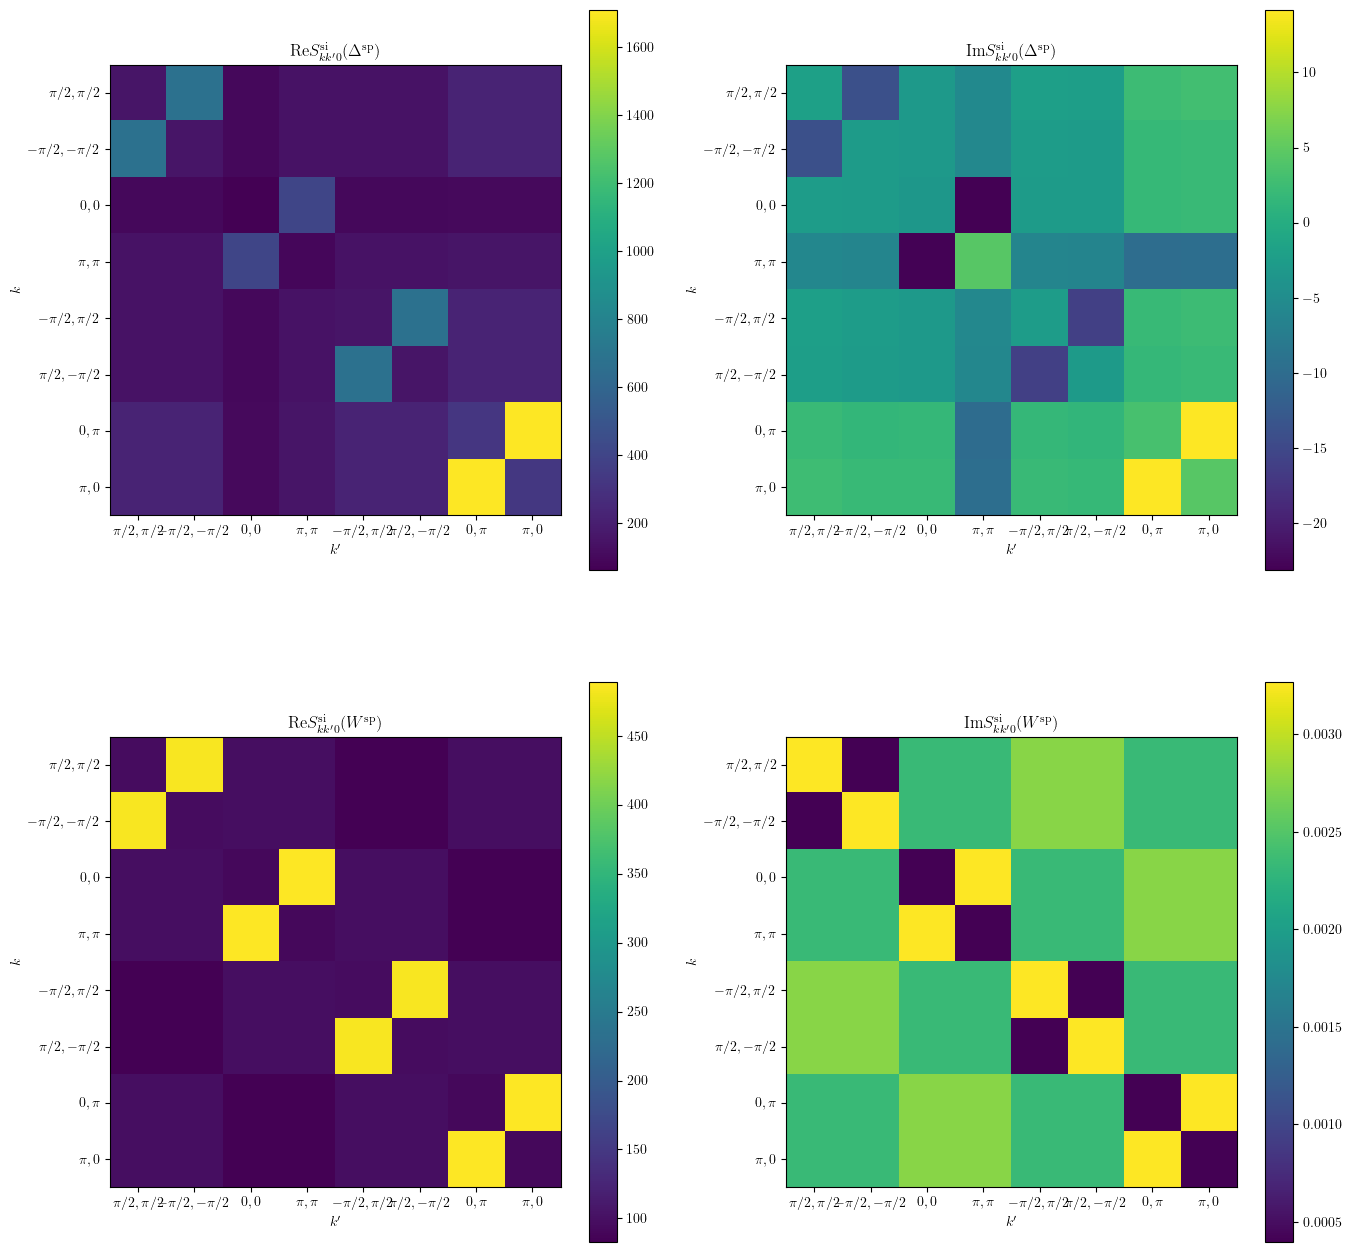

In [83]:
q = np.array([0.,0.])
omega_ind = 0
nu_ind = 1
nup_ind = 1
S_si_mat_k_kp = np.array([[S_si_sp(omega_ind, q, nu_ind, k, nup_ind, kp) for kp in k_points] for k in k_points])
S_si_mat_k_kp_0 = np.array([[S_si_sp_0(omega_ind, q, nu_ind, k, nup_ind, kp) for kp in k_points] for k in k_points])

# test_mat = np.array([[add_k_ind(k,np.array([0,0]),k_points)+100*add_k_ind(kp,np.array([0,0]),k_points) for kp in k_points] for k in k_points])
# fig, ax = plt.subplots(figsize=(5,5))
# im=ax.imshow(test_mat)
# #add color bar
# ax.figure.colorbar(im, ax=ax)
# ax.set_xlabel("$k'$")
# ax.set_ylabel("$k$")
# ax.set_xticks(np.arange(len(k_points)))
# ax.set_yticks(np.arange(len(k_points)))
# for i in range(len(k_points)):
#     for j in range(len(k_points)):
#         text = ax.text(j,i, test_mat[i, j].real,
#                        ha="center", va="center", color="w")

fig, axes = plt.subplots(2,2,figsize=(8*2,8*2))
im = axes[0,0].imshow(S_si_mat_k_kp.real)
axes[0,0].set_title("$\mathrm{Re} S_{kk'0}^{\mathrm{si}}(\Delta^{\mathrm{sp}})$")
axes[0,0].figure.colorbar(im, ax=axes[0,0])
im = axes[0,1].imshow(S_si_mat_k_kp.imag)
axes[0,1].set_title("$\mathrm{Im} S_{kk'0}^{\mathrm{si}}(\Delta^{\mathrm{sp}})$")
axes[0,1].figure.colorbar(im, ax=axes[0,1])
im = axes[1,0].imshow(S_si_mat_k_kp_0.real)
axes[1,0].set_title("$\mathrm{Re} S_{kk'0}^{\mathrm{si}}(W^{\mathrm{sp}})$")
axes[1,0].figure.colorbar(im, ax=axes[1,0])
im = axes[1,1].imshow(S_si_mat_k_kp_0.imag)
axes[1,1].set_title("$\mathrm{Im} S_{kk'0}^{\mathrm{si}}(W^{\mathrm{sp}})$")
axes[1,1].figure.colorbar(im, ax=axes[1,1])
for i in range(2):
    for j in range(2):
        axes[i,j].set_xticks(np.arange(len(k_points)))
        axes[i,j].set_yticks(np.arange(len(k_points)))
        axes[i,j].set_xticklabels(k_points_str)
        axes[i,j].set_yticklabels(k_points_str)
        axes[i,j].set_xlabel("$k'$")
        axes[i,j].set_ylabel("$k$") 

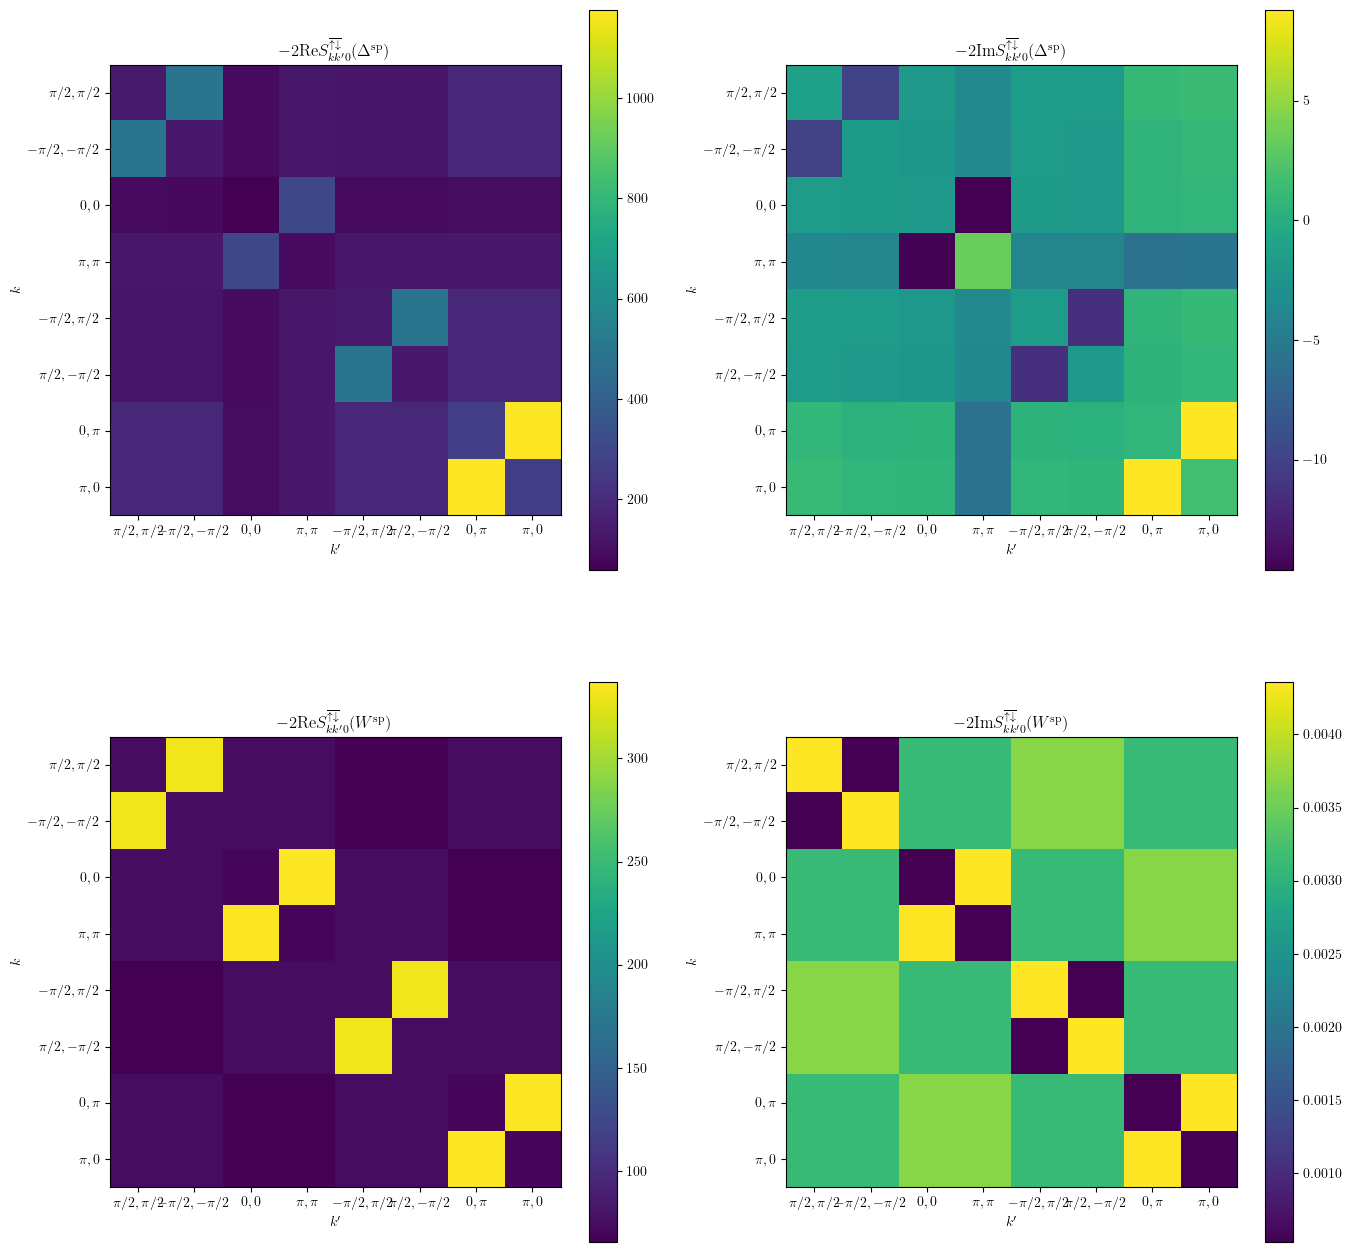

In [90]:
q = np.array([0.,0.])
omega_ind = 0
nu_ind = 1
nup_ind = 1
S_up_down_bar_mat_k_kp = np.array([[S_up_down_bar_sp(omega_ind, q, nu_ind, k, nup_ind, kp) for kp in k_points] for k in k_points])
S_up_down_bar_mat_k_kp_0 = np.array([[S_up_down_bar_sp_0(omega_ind, q, nu_ind, k, nup_ind, kp) for kp in k_points] for k in k_points])


fig, axes = plt.subplots(2,2,figsize=(8*2,8*2))
im = axes[0,0].imshow(-2*S_up_down_bar_mat_k_kp.real)
axes[0,0].set_title(r"$-2\mathrm{Re} S_{kk'0}^{\overline{\uparrow\downarrow}}(\Delta^{\mathrm{sp}})$")
axes[0,0].figure.colorbar(im, ax=axes[0,0])
im = axes[0,1].imshow(-2*S_up_down_bar_mat_k_kp.imag)
axes[0,1].set_title(r"$-2\mathrm{Im} S_{kk'0}^{\overline{\uparrow\downarrow}}(\Delta^{\mathrm{sp}})$")
axes[0,1].figure.colorbar(im, ax=axes[0,1])
im = axes[1,0].imshow(-2*S_up_down_bar_mat_k_kp_0.real)
axes[1,0].set_title(r"$-2\mathrm{Re} S_{kk'0}^{\overline{\uparrow\downarrow}}(W^{\mathrm{sp}})$")
axes[1,0].figure.colorbar(im, ax=axes[1,0])
im = axes[1,1].imshow(-2*S_up_down_bar_mat_k_kp_0.imag)
axes[1,1].set_title(r"$-2\mathrm{Im} S_{kk'0}^{\overline{\uparrow\downarrow}}(W^{\mathrm{sp}})$")
axes[1,1].figure.colorbar(im, ax=axes[1,1])
for i in range(2):
    for j in range(2):
        axes[i,j].set_xticks(np.arange(len(k_points)))
        axes[i,j].set_yticks(np.arange(len(k_points)))
        axes[i,j].set_xticklabels(k_points_str)
        axes[i,j].set_yticklabels(k_points_str)
        axes[i,j].set_xlabel("$k'$")
        axes[i,j].set_ylabel("$k$") 